In [2]:
# STEP 1: Import Libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import random

In [3]:
# STEP 2: Set Device and Parameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 64
SEQ_LEN = 10
BATCH_SIZE = 4
NUM_CLASSES = 5
HIDDEN_DIM = 128
EPOCHS = 10
DATA_DIR = "eye_gaze"

In [4]:
# STEP 3: Custom Dataset for Sequence Loading
class GazeSequenceDataset(Dataset):
    def __init__(self, root_dir, transform=None, seq_len=10):
        self.root_dir = root_dir
        self.transform = transform
        self.seq_len = seq_len
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = []

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            files = sorted([os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.endswith('.jpg')])
            # Create sequences from the sorted images
            for i in range(len(files) - seq_len + 1):
                seq = files[i:i+seq_len]
                self.samples.append((seq, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq_paths, label = self.samples[idx]
        seq = []
        for img_path in seq_paths:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            seq.append(img)
        seq = torch.stack(seq)  # shape: (seq_len, C, H, W)
        return seq, label


In [5]:
# STEP 4: Define Transforms and Load Datasets
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = GazeSequenceDataset(os.path.join(DATA_DIR, 'train'), transform=transform, seq_len=SEQ_LEN)
test_dataset = GazeSequenceDataset(os.path.join(DATA_DIR, 'test'), transform=transform, seq_len=SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train Sequences: {len(train_dataset)}")
print(f"Test Sequences: {len(test_dataset)}")

Train Sequences: 5955
Test Sequences: 1455


In [6]:
# STEP 5: Define the MobileNetV2 + LSTM Model
class MobileNetLSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=5, lstm_layers=1):
        super(MobileNetLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Freeze all except last two layers (17 and 18)
        for name, param in self.feature_extractor.named_parameters():
            if "17" not in name and "18" not in name:
                param.requires_grad = False

        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim,
                            num_layers=lstm_layers, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)  # (B*T, C, H, W)

        with torch.no_grad():
            features = self.feature_extractor(x)
            features = self.pool(features).view(features.size(0), -1)

        features = features.view(b, t, -1)         # (B, T, 1280)
        lstm_out, _ = self.lstm(features)          # (B, T, hidden_dim)
        final_output = lstm_out[:, -1, :]          # Last time-step
        return self.classifier(final_output)

In [7]:
# STEP 6: Train the Model
model = MobileNetLSTM(hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES).to(DEVICE)

# ✅ Unfreeze final layers for fine-tuning
for name, param in model.feature_extractor.named_parameters():
    if "18" in name or "17" in name:
        param.requires_grad = True

# ✅ Apply label smoothing and scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for sequences, labels in train_loader:
        sequences, labels = sequences.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate batch accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


c:\Users\nelly\Desktop\Bea_Tap\bea_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nelly\Desktop\Bea_Tap\bea_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.6348, Accuracy: 89.84%
Epoch [2/10], Loss: 0.4713, Accuracy: 98.25%
Epoch [3/10], Loss: 0.4532, Accuracy: 98.72%
Epoch [4/10], Loss: 0.4407, Accuracy: 99.06%
Epoch [5/10], Loss: 0.4384, Accuracy: 99.28%
Epoch [6/10], Loss: 0.4198, Accuracy: 99.61%
Epoch [7/10], Loss: 0.4151, Accuracy: 99.71%
Epoch [8/10], Loss: 0.4125, Accuracy: 99.76%
Epoch [9/10], Loss: 0.4112, Accuracy: 99.75%
Epoch [10/10], Loss: 0.4111, Accuracy: 99.73%


In [51]:
# STEP 7: Save the Trained Model
torch.save(model.state_dict(), "eye_gaze_lstm_model.pth")
print("Model saved as 'eye_gaze_lstm_model.pth'")

Model saved as 'eye_gaze_lstm_model.pth'


In [10]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

        down       1.00      1.00      1.00       291
        left       1.00      1.00      1.00       291
       right       1.00      1.00      1.00       291
    straight       1.00      1.00      1.00       291
          up       1.00      1.00      1.00       291

    accuracy                           1.00      1455
   macro avg       1.00      1.00      1.00      1455
weighted avg       1.00      1.00      1.00      1455



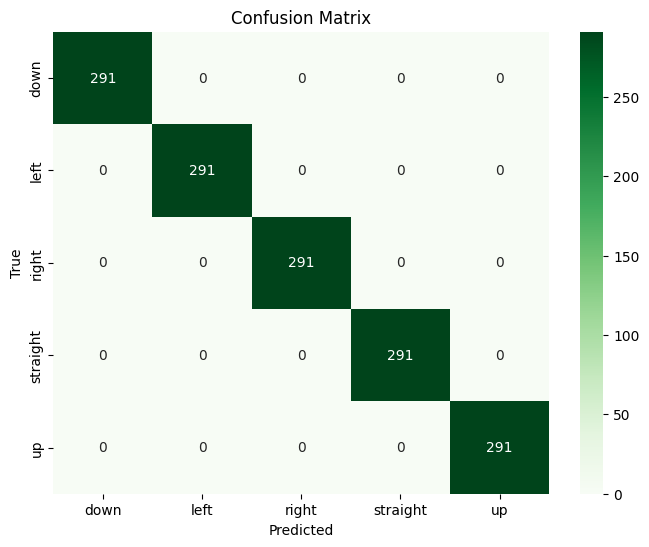

In [12]:
# STEP 8: Evaluate After Training
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(DEVICE), labels.to(DEVICE)
        outputs = model(sequences)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [66]:
# MobileNetLSTM Model Definition
import torch.nn as nn
from torchvision import models

class MobileNetLSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=5, lstm_layers=1):
        super(MobileNetLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim,
                            num_layers=lstm_layers, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
            x = x.view(x.size(0), -1)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        return self.classifier(out)


In [ ]:
import torch.nn as nn
from torchvision import models

class MobileNetLSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=5, lstm_layers=1):
        super(MobileNetLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim,
                            num_layers=lstm_layers, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
            x = x.view(x.size(0), -1)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        return self.classifier(out)


In [78]:
# STEP 9: Real-Time Webcam Eye Gaze Shift Counter (Debounced, Accurate)
import cv2
import torch
import time
import mediapipe as mp
from collections import deque
from torchvision import transforms
import torch.nn as nn
from torchvision import models

# === Define MobileNetLSTM ===
class MobileNetLSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=5, lstm_layers=1):
        super(MobileNetLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim,
                            num_layers=lstm_layers, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
            x = x.view(x.size(0), -1)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        return self.classifier(out)

# === Constants ===
HIDDEN_DIM = 128
NUM_CLASSES = 5
SEQ_LEN = 10
IMG_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load Model ===
model = MobileNetLSTM(hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("eye_gaze_lstm_model.pth", map_location=DEVICE))
model.eval()

# === Transform ===
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# === MediaPipe Setup ===
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1,
                                   refine_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)
LEFT_EYE_IDS = [33, 133, 159, 145]
RIGHT_EYE_IDS = [362, 263, 386, 374]

# === Buffers ===
frame_buffer = deque(maxlen=SEQ_LEN)
recent_preds = deque(maxlen=3)
prev_confirmed_label = None
gaze_shift_count = 0
last_valid_time = time.time()
debounce_interval = 0.75  # seconds

# === Webcam ===
cap = cv2.VideoCapture(0)
print("🔵 Press 'q' to quit")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    h, w, _ = frame.shape
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark
        eye_x = [int(landmarks[i].x * w) for i in LEFT_EYE_IDS + RIGHT_EYE_IDS]
        eye_y = [int(landmarks[i].y * h) for i in LEFT_EYE_IDS + RIGHT_EYE_IDS]

        x_min = max(min(eye_x) - 20, 0)
        x_max = min(max(eye_x) + 20, w)
        y_min = max(min(eye_y) - 20, 0)
        y_max = min(max(eye_y) + 20, h)

        eye_crop = rgb[y_min:y_max, x_min:x_max]
        if eye_crop.size == 0:
            continue

        for idx in LEFT_EYE_IDS + RIGHT_EYE_IDS:
            cx, cy = int(landmarks[idx].x * w), int(landmarks[idx].y * h)
            cv2.circle(frame, (cx, cy), 2, (0, 255, 0), -1)

        img_tensor = transform(cv2.resize(eye_crop, (IMG_SIZE, IMG_SIZE)))
        frame_buffer.append(img_tensor)

        if len(frame_buffer) == SEQ_LEN:
            with torch.no_grad():
                seq_input = torch.stack(list(frame_buffer)).unsqueeze(0).to(DEVICE)
                output = model(seq_input)
                _, pred = torch.max(output, 1)
                label = pred.item()
                recent_preds.append(label)

            # Confirmed label only if 3 most recent are identical
            if recent_preds.count(label) == len(recent_preds):
                now = time.time()
                if label != prev_confirmed_label and now - last_valid_time > debounce_interval:
                    gaze_shift_count += 1
                    prev_confirmed_label = label
                    last_valid_time = now

    cv2.putText(frame, f"Gaze Shifts: {gaze_shift_count}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)

    cv2.imshow("Eye Gaze Shift Counter", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
face_mesh.close()


🔵 Press 'q' to quit


In [1]:
import cv2
import torch
import time
import mediapipe as mp
from tkinter import Tk, Button, Label, filedialog
from torchvision import transforms
from collections import deque
import torch.nn as nn
from torchvision import models
import numpy as np

# === Define Model ===
class MobileNetLSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=5):
        super(MobileNetLSTM, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_dim,
                            batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(-1, c, h, w)
        with torch.no_grad():
            x = self.feature_extractor(x)
            x = self.pool(x)
            x = x.view(x.size(0), -1)
        x = x.view(b, t, -1)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        return self.classifier(out)

# === Load Model ===
model = MobileNetLSTM(hidden_dim=128, num_classes=5)
model.load_state_dict(torch.load("eye_gaze_lstm_model.pth", map_location="cpu"))
model.eval()

# === Preprocessing ===
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# === MediaPipe Setup ===
mp_face_mesh = mp.solutions.face_mesh
LEFT_EYE_IDS = [33, 133, 159, 145]
RIGHT_EYE_IDS = [362, 263, 386, 374]

def count_gaze_shifts(video_path):
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1,
                                      refine_landmarks=True, min_detection_confidence=0.5,
                                      min_tracking_confidence=0.5)
    cap = cv2.VideoCapture(video_path)
    frame_buffer = deque(maxlen=10)
    recent_preds = deque(maxlen=3)
    prev_label = None
    gaze_shifts = 0
    debounce_time = time.time()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        h, w, _ = frame.shape
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb)

        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0].landmark
            eye_x = [int(landmarks[i].x * w) for i in LEFT_EYE_IDS + RIGHT_EYE_IDS]
            eye_y = [int(landmarks[i].y * h) for i in LEFT_EYE_IDS + RIGHT_EYE_IDS]

            x_min = max(min(eye_x) - 20, 0)
            x_max = min(max(eye_x) + 20, w)
            y_min = max(min(eye_y) - 20, 0)
            y_max = min(max(eye_y) + 20, h)

            eye_crop = rgb[y_min:y_max, x_min:x_max]
            if eye_crop.size == 0:
                continue

            img_tensor = transform(cv2.resize(eye_crop, (64, 64)))
            frame_buffer.append(img_tensor)

            if len(frame_buffer) == 10:
                with torch.no_grad():
                    input_seq = torch.stack(list(frame_buffer)).unsqueeze(0)
                    out = model(input_seq)
                    _, pred = torch.max(out, 1)
                    label = pred.item()
                    recent_preds.append(label)

                # Count shift only if new consistent label appears
                if recent_preds.count(label) == len(recent_preds):
                    now = time.time()
                    if label != prev_label and now - debounce_time > 0.75:
                        gaze_shifts += 1
                        prev_label = label
                        debounce_time = now

    cap.release()
    face_mesh.close()
    return gaze_shifts

# === GUI Function ===
def browse_and_analyze():
    file_path = filedialog.askopenfilename(filetypes=[("Video files", "*.mp4;*.avi;*.mov")])
    if file_path:
        result_label.config(text="Analyzing video, please wait...")
        root.update()
        shifts = count_gaze_shifts(file_path)
        result_label.config(text=f"🎯 Eye Gaze Shift Count: {shifts}")

# === Tkinter GUI ===
root = Tk()
root.title("Eye Gaze Shift Counter")
root.geometry("400x200")

button = Button(root, text="Upload Video File", command=browse_and_analyze, font=("Arial", 12))
button.pack(pady=30)

result_label = Label(root, text="", font=("Arial", 14))
result_label.pack()

root.mainloop()

c:\Users\nelly\Desktop\Bea_Tap\bea_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nelly\Desktop\Bea_Tap\bea_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
